In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
import math

from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[0]).unwrapped

discrete_actions = True

if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
    
import gc

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
output_num = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
input_num = output_num*2
all_a = 1

In [2]:
def evolve(population,population_out_size,gen,p_fitness,mutation_rate,mutation_scale):
    #Chose creatures based on fitness
    sort = np.argsort(np.max(p_fitness)-p_fitness)
    choice = []
    for i in range(population_out_size+1):
        ex = (population_out_size)/4#population_out_size
        ex = math.ceil(ex**(1/(i+1)))
        for _ in range(int(ex)):
            choice.append(sort[i%(len(p_fitness)-1)])
        if len(choice) > population_out_size+1:
            choice = choice[:population_out_size+1]
            break
    np.random.shuffle(choice)
    
    #mate and mutate creatures
    new_population = []
    for p in range(population_out_size):
        #Pick parents
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        
        child = mate(env,creature_out_size,all_a,device,first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    return new_population

In [3]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    gen_explore_all = []
    gen_exploit_all = []
    a_gen_all = []
    dis_loss_all = []
    dis_confidence_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        ind = np.arange(len(population))
        np.random.shuffle(ind)
        population = np.array(population)[ind]
        p_fitness = p_fitness[ind]
        for i in range(len(population)//batch_size):
            
            #turn population into vectors
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            dis_out_r = dis(real_batch).squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = (nn.MSELoss()(dis_out_r[...,0],rank))
            dis_error_real.backward(retain_graph=True)
            
            #discriminator confidence in its prediction
            dis_confidence = torch.mean(torch.abs(dis_out_r[...,1]-dis_error_real.detach()))
            dis_error_real.backward()
            
            dis_optimizer.step() 
            
            #generate children from population
            child,a_gen = gen_children(population,device,gen,batch_size,a = all_a)
            a_gen = torch.mean(torch.abs(a_gen))
            #print("A gen : {}".format(torch.mean(a_gen)))
            #train discriminator
            dis_out_f = dis(child).squeeze(-1)
            gen_optimizer.zero_grad()
            
            #define generator loss
            exploration = torch.std(dis_out_f[...,0])
            
            gen_error_exploration =  -exploration-torch.mean(dis_out_f[...,1])+ a_gen
            gen_error_exploitation = -torch.mean(dis_out_f[...,0]) #+ torch.mean(a_gen)
            gen_error = gen_error_exploration + gen_error_exploitation 
            
            gen_error.backward()
            gen_optimizer.step() 
            
            #keep losses to draw graph 
            a_gen_all.append(a_gen)
            gen_explore_all.append(gen_error_exploration)
            gen_exploit_all.append(gen_error_exploitation)
            dis_loss_all.append(dis_error_real)  
            dis_confidence_all.append(dis_confidence)
    #print(rank)
    #print(dis_out_r)
    #print(get_params(population[0]))
    #print()
            
    return gen_explore_all,gen_exploit_all, dis_loss_all,a_gen_all,dis_confidence_all


starting training
142
Measured population fitness : 0s
population fitness : [20.  9.  9. 10.  9. 16.  9. 10.  9. 15.]
mean fit : 11.6
Trained GAN : 1s
Evolved : 0s


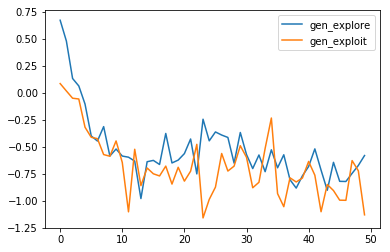

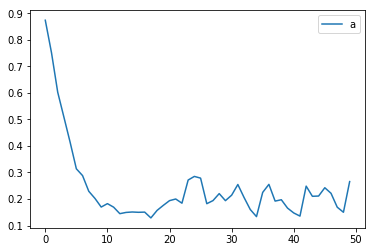

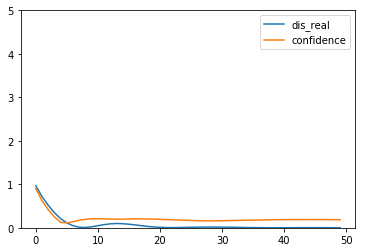

Generation 1  fitness : 20.0
#################################
Measured population fitness : 0s
population fitness : [10. 10. 12.  8. 31.  9. 43. 13. 10. 17.]
mean fit : 16.3
Trained GAN : 1s
Evolved : 0s


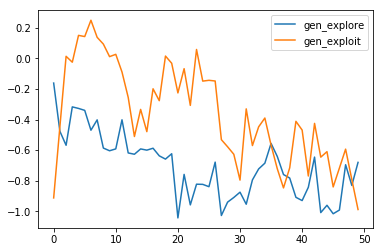

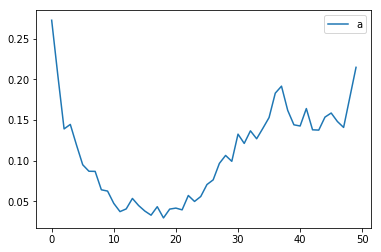

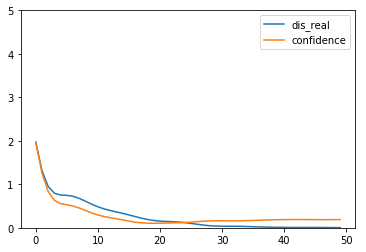

Generation 2  fitness : 43.0
#################################
Measured population fitness : 0s
population fitness : [17. 32. 35. 14. 35. 25. 25.  9. 19. 25.]
mean fit : 23.6
Trained GAN : 1s
Evolved : 0s


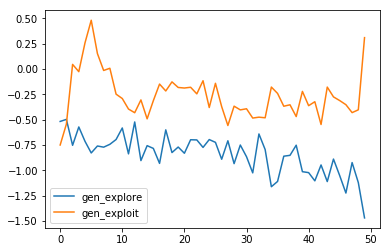

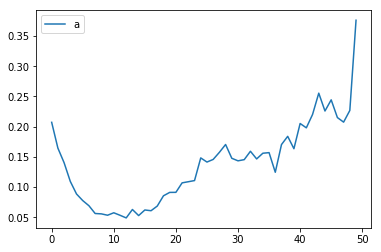

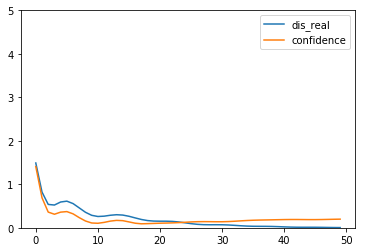

Generation 3  fitness : 35.0
#################################
Measured population fitness : 0s
population fitness : [ 16.  20.  10.  25.  18.  10.  11.  10.  11. 287.]
mean fit : 41.8
Trained GAN : 1s
Evolved : 0s


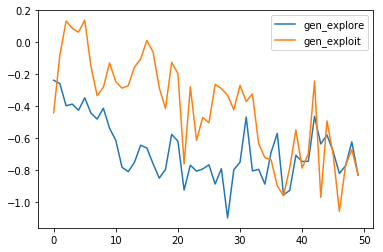

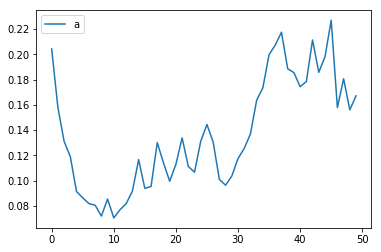

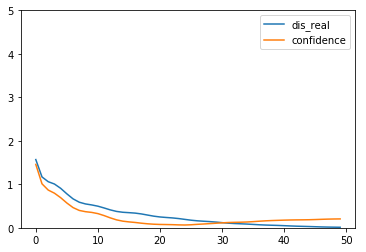

Generation 4  fitness : 287.0
#################################
Measured population fitness : 0s
population fitness : [11. 33. 22. 16. 10. 41. 12. 12. 23. 12.]
mean fit : 19.2
Trained GAN : 1s
Evolved : 0s


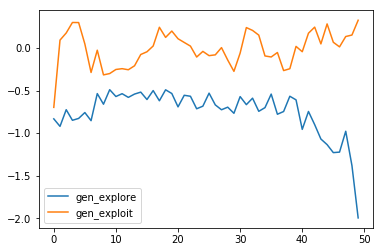

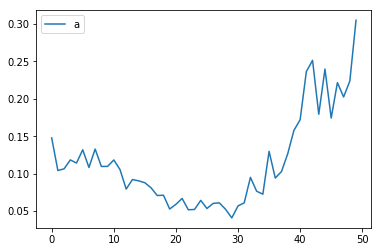

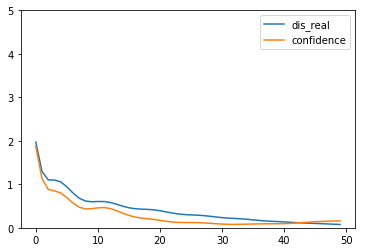

Generation 5  fitness : 41.0
#################################
Measured population fitness : 0s
population fitness : [67. 66. 41. 29. 27. 16. 43. 23. 18. 14.]
mean fit : 34.4
Trained GAN : 1s
Evolved : 0s


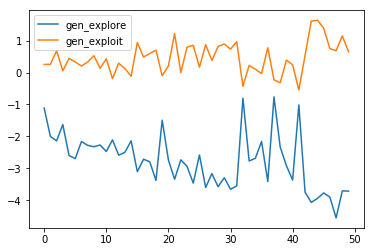

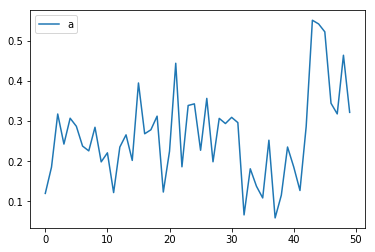

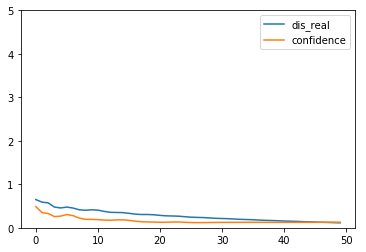

Generation 6  fitness : 67.0
#################################
Measured population fitness : 0s
population fitness : [40. 15. 24. 23. 24. 43. 20. 36. 36. 11.]
mean fit : 27.2
Trained GAN : 1s
Evolved : 0s


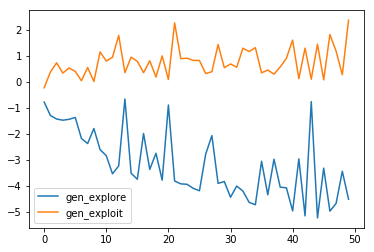

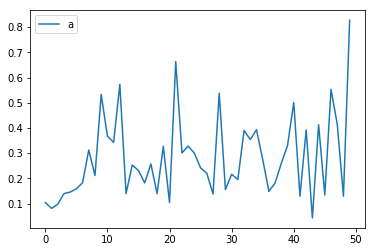

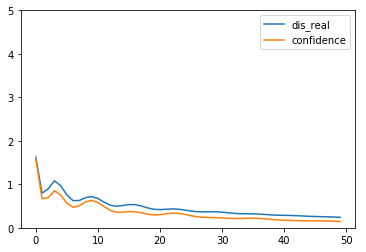

Generation 7  fitness : 43.0
#################################
Measured population fitness : 0s
population fitness : [13. 65. 36. 27. 73. 36. 26. 32. 24. 15.]
mean fit : 34.7
Trained GAN : 1s
Evolved : 0s


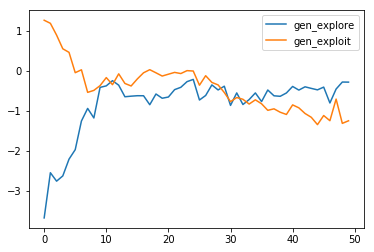

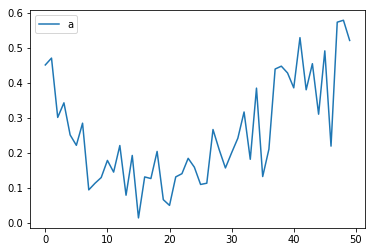

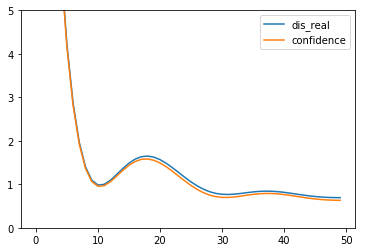

Generation 8  fitness : 73.0
#################################
Measured population fitness : 0s
population fitness : [39. 43. 49. 50. 33. 19. 42. 60. 25. 91.]
mean fit : 45.1
Trained GAN : 1s
Evolved : 0s


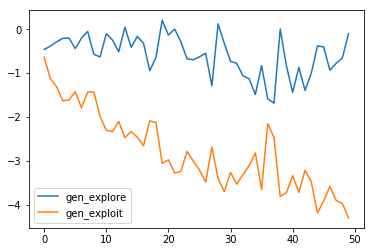

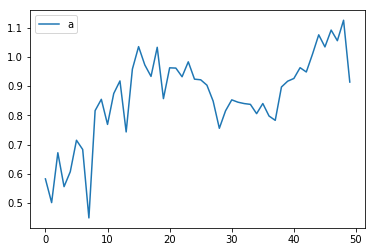

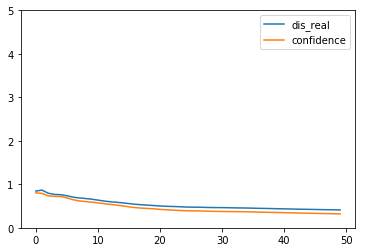

Generation 9  fitness : 91.0
#################################
Measured population fitness : 0s
population fitness : [36. 46. 57. 26. 24. 31. 29. 37. 31. 25.]
mean fit : 34.2
Trained GAN : 1s
Evolved : 0s


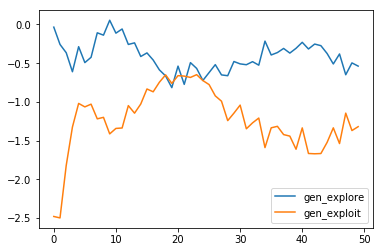

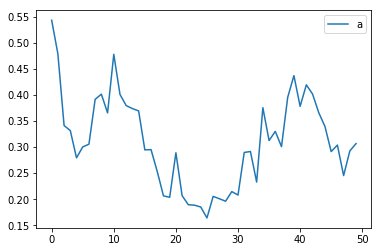

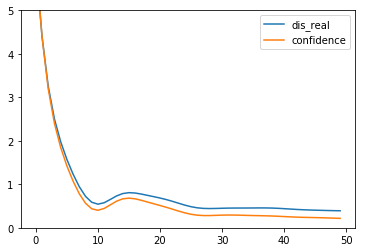

Generation 10  fitness : 57.0
#################################
Measured population fitness : 1s
population fitness : [  42.   35.   44. 2000. 2000.  189.   24.   53.   45.   32.]
mean fit : 446.4
Trained GAN : 1s
Evolved : 0s


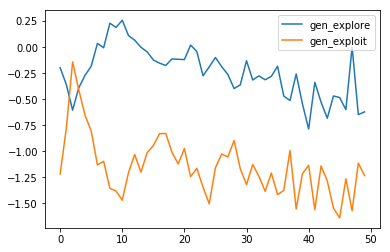

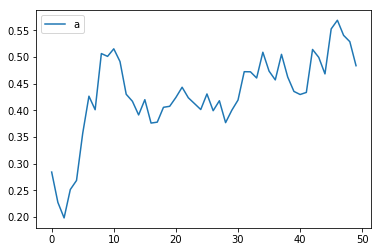

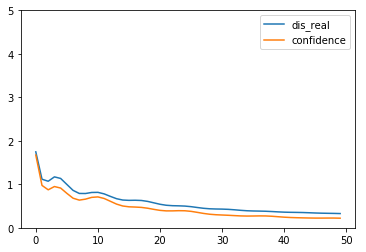

Generation 11  fitness : 2000.0
#################################
Measured population fitness : 1s
population fitness : [2000.  230.  103. 2000.   79.   94.   94.   56.   54. 2000.]
mean fit : 671.0
Trained GAN : 1s
Evolved : 0s


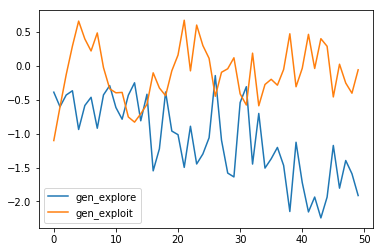

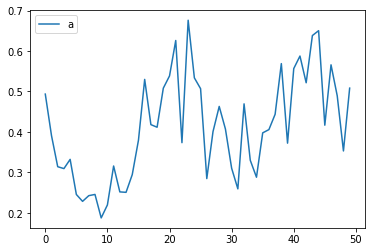

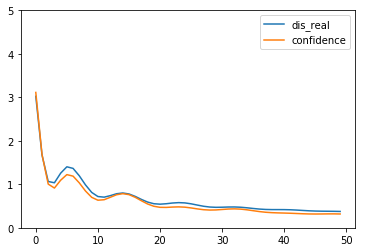

Generation 12  fitness : 2000.0
#################################
Measured population fitness : 0s
population fitness : [  46.   42.   16. 2000.   28.  100.   20.   74.   35.   32.]
mean fit : 239.3
Trained GAN : 1s
Evolved : 0s


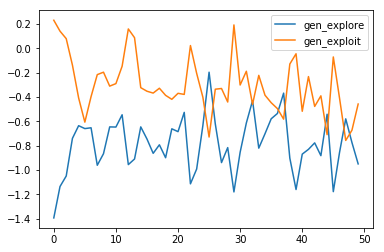

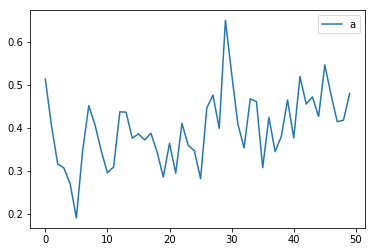

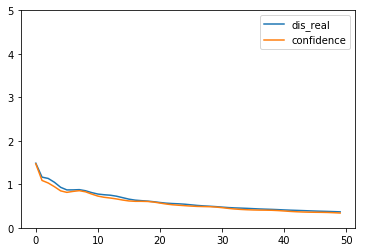

Generation 13  fitness : 2000.0
#################################
Measured population fitness : 0s
population fitness : [ 84. 133.  28.  18.  71.   8.   8. 222.  30.  28.]
mean fit : 63.0
Trained GAN : 1s
Evolved : 0s


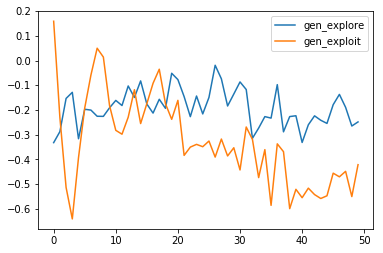

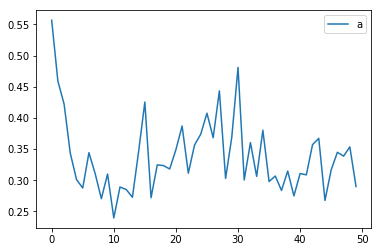

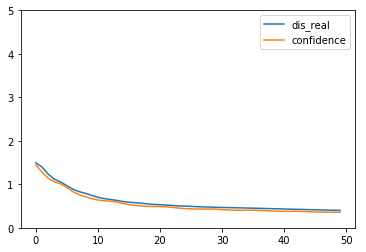

Generation 14  fitness : 222.0
#################################
Measured population fitness : 0s
population fitness : [452. 126. 107. 124. 146.  96.  29.  11.  36. 196.]
mean fit : 132.3
Trained GAN : 1s
Evolved : 0s


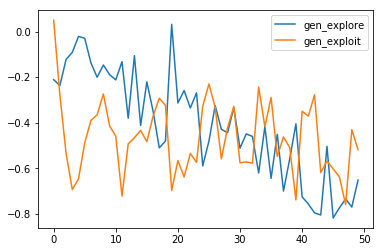

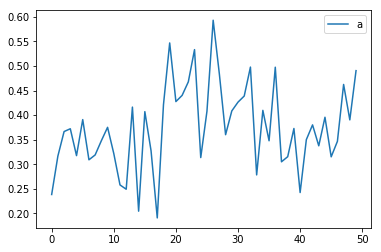

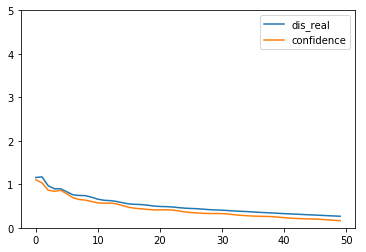

Generation 15  fitness : 452.0
#################################
Measured population fitness : 0s
population fitness : [ 107.  114. 2000.   93.  240.  129.  143.  131.  100.  184.]
mean fit : 324.1
Trained GAN : 1s
Evolved : 0s


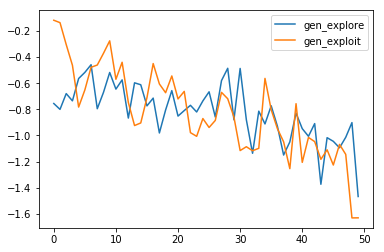

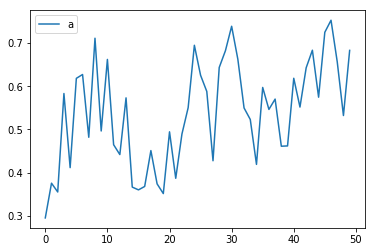

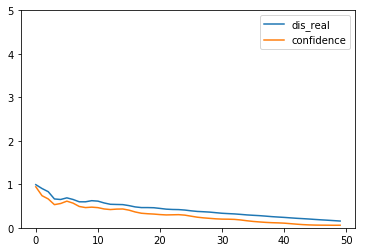

Generation 16  fitness : 2000.0
#################################
Measured population fitness : 1s
population fitness : [ 151.  311.   18.  285. 2000.   84.  100.  873.  250. 2000.]
mean fit : 607.2
Trained GAN : 1s
Evolved : 0s


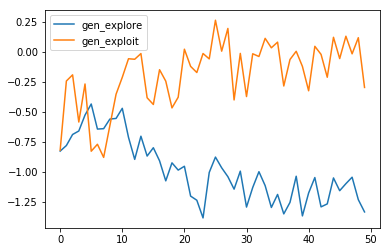

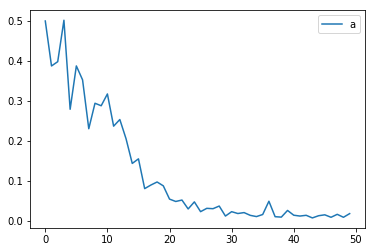

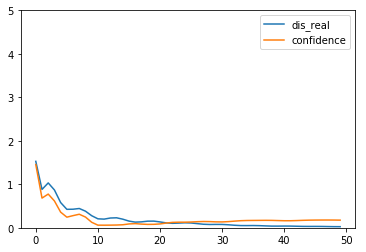

Generation 17  fitness : 2000.0
#################################
Measured population fitness : 3s
population fitness : [2000. 2000. 2000. 2000. 1201. 2000.  224. 2000.   72. 2000.]
mean fit : 1549.7
Trained GAN : 1s
Evolved : 0s


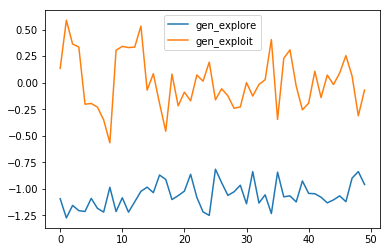

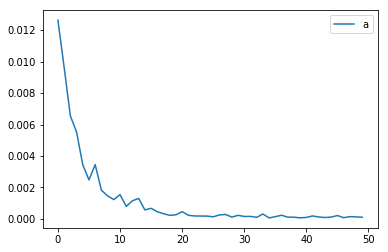

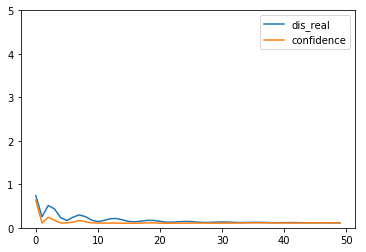

Generation 18  fitness : 2000.0
#################################
Measured population fitness : 3s
population fitness : [2000. 2000. 2000.  450. 2000.  233. 2000.  514.  532. 2000.]
mean fit : 1372.9
Trained GAN : 1s
Evolved : 0s


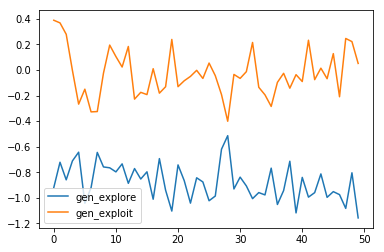

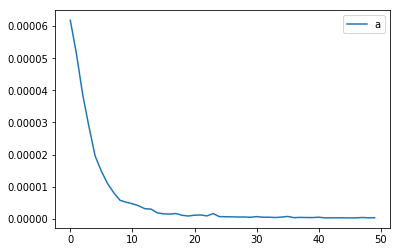

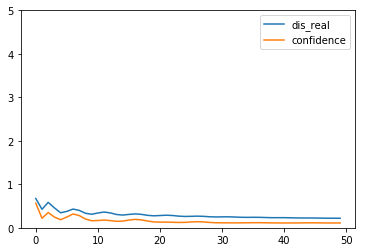

Generation 19  fitness : 2000.0
#################################
Measured population fitness : 4s
population fitness : [2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]
mean fit : 2000.0
Trained GAN : 1s
Evolved : 0s


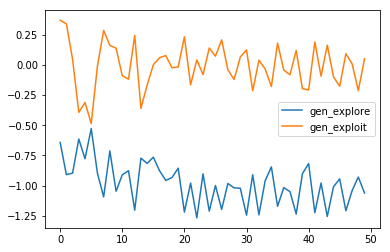

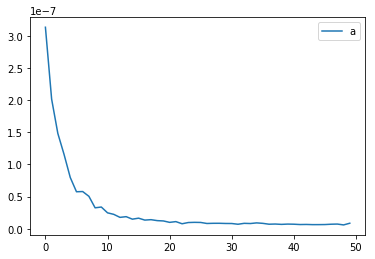

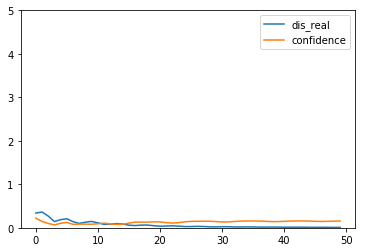

Generation 20  fitness : 2000.0
#################################
Measured population fitness : 4s
population fitness : [2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]
mean fit : 2000.0
Trained GAN : 1s
Evolved : 0s


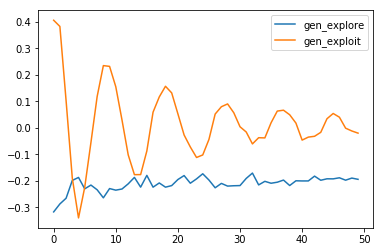

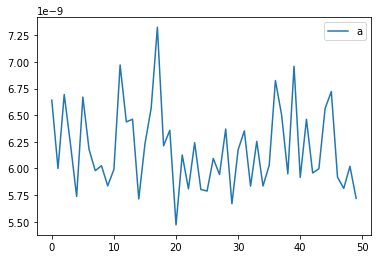

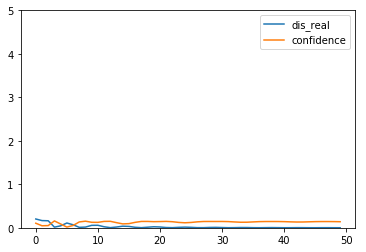

Generation 21  fitness : 2000.0
#################################


In [ ]:
population_size = 10
max_population = population_size
max_population_batch = 2
out_size = population_size
n_generations = 300

#randomly inititialise starting population
population = []
for p in range(population_size):
    creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)
    pars = torch.tanh(get_params(creat))
    creat = set_params(creat,pars)
    population.append(creat)


print("starting training")
print(len(get_params(Creature(env.observation_space.shape[0],creature_out_size))))

old_population = []
old_fitnesses = []
gen = Generator(input_num,output_num,device).to(device)
dis = Discriminator().to(device)

for i in range(n_generations):
    
    #all_a *= 0.9
    start_time = time.time()
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0002,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.0002,betas=(0.9,0.999))
   
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))

    #setup data for GAN
    population_batch = np.concatenate(np.array(old_population))
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    
    #normalize fitnesses
    epsilon = 0.000001
    fitness_batch = ((fitness_batch - np.mean(fitness_batch))/np.sqrt(np.var(fitness_batch)+epsilon))
    #fitness_batch = np.minimum(0,fitness_batch)
    #Train GAN
    start_time = time.time()
    gen_explore_all,gen_exploit_all, dis_loss ,a_gen_all,dis_confidence_all= train_gan(population_batch,fitness_batch,
              batch_size =fitness_batch.size,n_epochs = 50)
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
    
    #Scale of normal distribution used for mutation
    mutation_scale = 0#.1
    mutation_rate = 0#.3
    mutation_rate = np.random.choice([0.1, 0], p_fitness_.shape,p=[mutation_rate,1-mutation_rate])
    
    #mate and mutate population
    start_time = time.time()
    population = evolve(population,out_size,gen,p_fitness_,
                                        mutation_rate,mutation_scale)
    print("Evolved : {}s".format(int(time.time() - start_time)))
    
    plt.plot(gen_explore_all,label='gen_explore')
    plt.plot(gen_exploit_all,label='gen_exploit')
    plt.legend()
    plt.show()
    plt.plot(a_gen_all,label='a')
    plt.legend()
    plt.show()
    plt.plot(dis_loss,label='dis_real')
    plt.plot(dis_confidence_all,label='confidence')
    plt.ylim(0,5)
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")


In [ ]:
#env = gym.make(envs[-2]).unwrapped

p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)


In [ ]:
fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 50000)
print(fitness)